<a href="https://colab.research.google.com/github/Jmmostafa/DerivativePricing/blob/main/DP003BS_BP_TP_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Derivative Pricing II- Options**

|  |  |
|:---|:---|
|**Developed By** |  Md Mostafa Kamal |
|**Date** | October 1, 2025  |
|**Covered** | Options Pricing -- Monte Carlo Simulation, Application |
|**Python** | OOP, Numpy, Pandas, Scienceplots, Matplotlib|
|**Sequence** | DP003 |


---

# **Introduction**

Earlier Notebooks, I already applied BS, binomial and trinomail options pricing models. In this notebook, I explore the Monte Carlo methods to tackle the problems. As it's now pretty comprehensible that earlier models have some drawbacks and assumptions which might not be practical in terms of real-world issues, however, MC model provide better flexibiltiy, even crucial for some path dependent options pricing. Here are some notable benefits of using MC models:


Options pricing is about computing the (discounted) expected payoff of a derivative under an appropriate probability measure. For European options on non-dividend-paying stocks it's common to model the stock price by geometric Brownian motion (GBM) and price the option using the Black–Scholes (BS) closed-form formula under the *risk-neutral* measure. Monte Carlo (MC) simulation offers a flexible alternative: simulate terminal stock prices, compute payoffs, discount, and average.

This notebook demonstrates Monte Carlo pricing for a European call, compares it to the Black–Scholes price, and explores how the Monte Carlo estimate behaves when you simulate using a *real-world* drift for the underlying (i.e., a drift ≠ risk-free rate). We also include variance reduction (antithetic variates and a control variate built from the terminal stock) and convergence plots.



# **Mathematical Framework and Formulae**


Assume the stock price follows a *Geometric Brownian Motion* under the real-world measure P:

$$dS_t = \mu S_t dt + \sigma S_t dW_t^P, \qquad S_0 > 0$$

Under the **risk-neutral** measure Q the drift becomes the risk-free rate (r):

$$dS_t = r S_t dt + \sigma S_t dW_t^Q.$$

## **BS Model**

**Closed-form (Black--Scholes)** price for a European call with strike $K$ and maturity $T$ (no dividends):

Let
$$d_{1,2} = \frac{\ln(S_0/K) + (r \pm \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}},$$
then
$$C_{BS} = S_0\,\Phi(d_1) - K e^{-rT} \Phi(d_2),$$
where $\Phi$ is the standard normal CDF.

## **Monte Carlo Method**

Monte Carlo (risk-neutral) estimator for the call price:

Simulate $S_T^{(i)}$ from the risk-neutral dynamics:
$$S_T = S_0 \exp\left((r - \tfrac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z\right), \quad Z\sim N(0,1).$$

Compute payoff $X^{(i)} = e^{-rT}\max(S_T^{(i)} - K,0)$. The MC estimator is
$$\hat{C}_{MC} = \frac{1}{N}\sum_{i=1}^N X^{(i)}$$
with sample standard error
$$\text{SE} = \frac{\widehat{\mathrm{std}}(X)}{\sqrt{N}}.$$

If we simulate under the real-world drift $\mu$ instead of $r$, the discounted expectation $e^{-rT}\mathbb{E}^P[\max(S_T-K,0)]$ will generally *not* equal the Black–Scholes price — this demonstrates the importance of using the risk-neutral measure for pricing.

## **Variance Reduction Methods**

1. **Antithetic variates:** For each normal $Z$ simulate also $-Z$ and average the two payoffs.

2. **Control variate (terminal stock):** Use the discounted terminal stock price $Y = e^{-rT} S_T$ as a control variate. We know its expectation under the risk-neutral measure:
$$\mathbb{E}^Q[Y] = e^{-rT} \mathbb{E}^Q[S_T] = e^{-rT} S_0 e^{rT} = S_0.$$
Given MC payoff $X$ and control $Y$, use
$$\hat{X}_{cv} = \bar{X} - \beta (\bar{Y} - \mathbb{E}[Y]),$$
with $\beta$ chosen as $\beta^* = \mathrm{Cov}(X,Y)/\mathrm{Var}(Y)$ (estimated from the sample).



In [ ]:
!pip install yfinance numpy scipy matplotlib scienceplots --quiet
!apt-get update -qq
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

OPTION PRICING ANALYSIS
S0=100, K=100, r=0.01, sigma=0.2, T=1
Option type: C
Black-Scholes price: 8.433319
Plain MC (risk-netural)   price: 8.442617  SE: 0.030108  Error: 0.009298
Antithetic Variates       price: 8.436589  SE: 0.030135  Error: 0.003271
Control Variate           price: 8.447339  SE: 0.013298  Error: 0.014021
  -> Control variate beta: 0.597706
Real-world (mu=0.08)      price: 12.999062  SE: 0.037393  Error: 4.565743


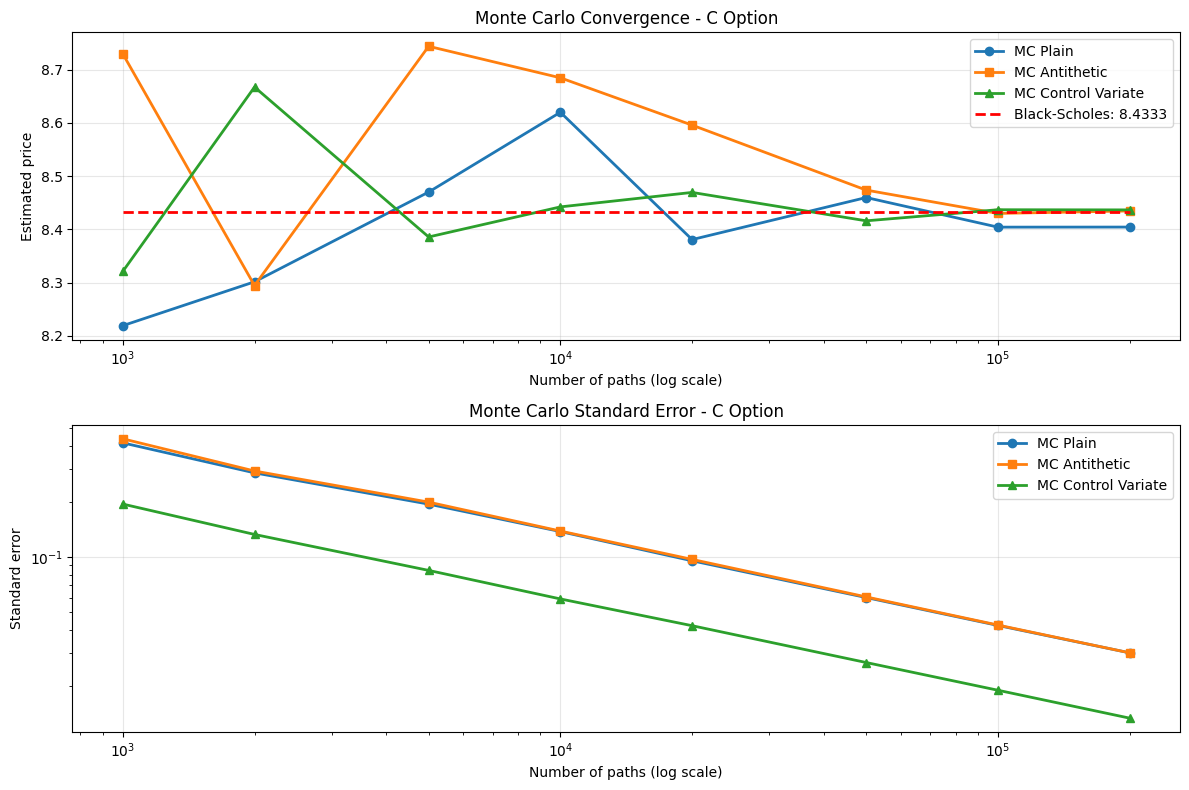

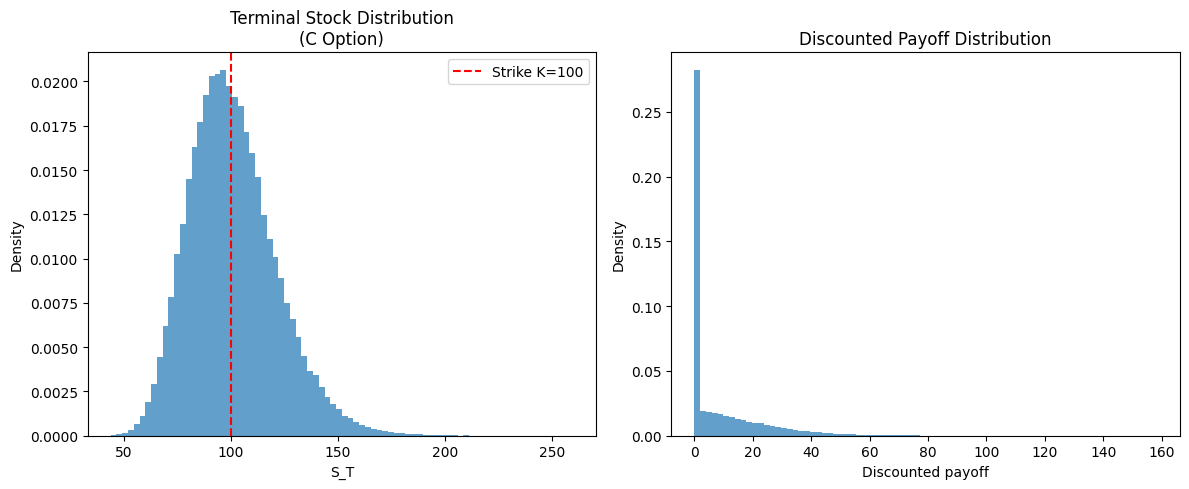


PUT OPTION ANALYSIS
OPTION PRICING ANALYSIS
S0=100, K=100, r=0.01, sigma=0.2, T=1
Option type: P
Black-Scholes price: 7.438302
Plain MC (risk-netural)   price: 7.439380  SE: 0.022485  Error: 0.001078
Antithetic Variates       price: 7.436712  SE: 0.022456  Error: 0.001591
Control Variate           price: 7.441111  SE: 0.013296  Error: 0.002809
  -> Control variate beta: -0.400092
Real-world (mu=0.08)      price: 4.736759  SE: 0.018331  Error: 2.701543


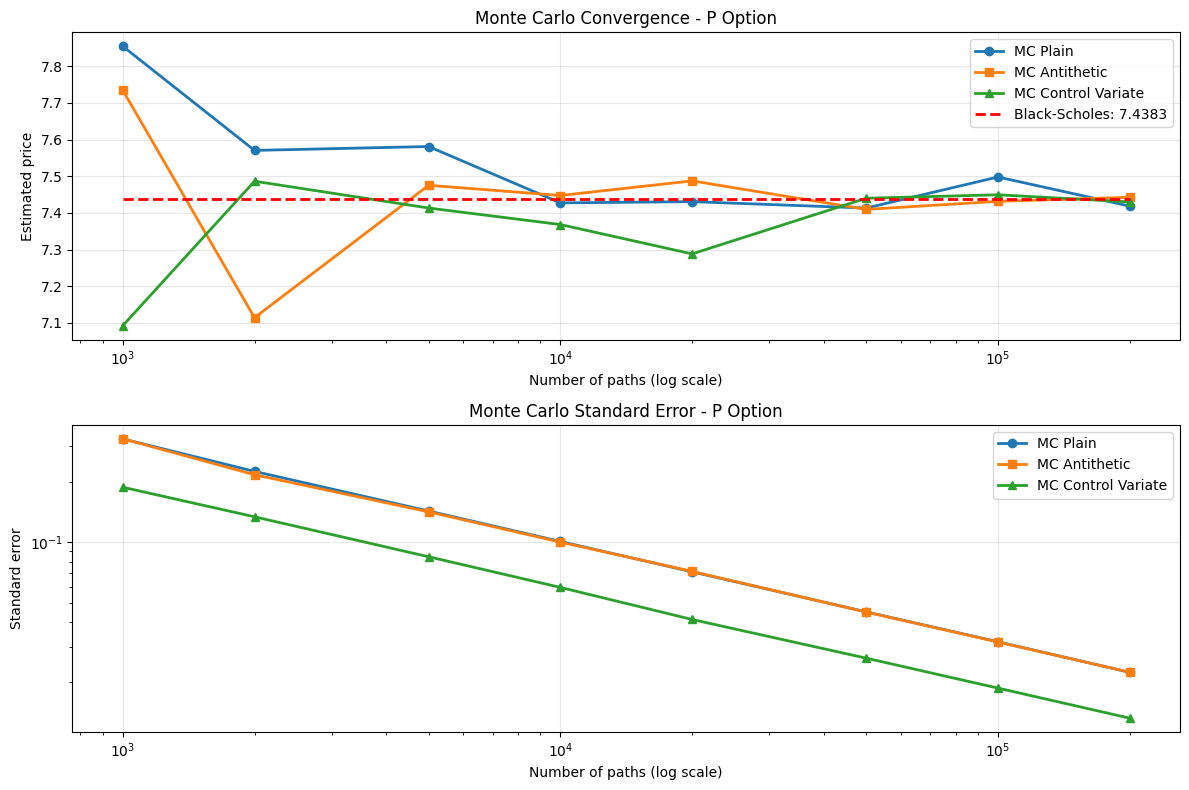

In [3]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from math import log, sqrt, exp

np.random.seed(42)

# Creating OOP command pricing under BS and Monte Carlo

class BS_Model:
  def __init__(self, S0, K, r, sigma, T, option_type='C'):
    self.S0 = S0
    self.K = K
    self.r = r
    self.sigma = sigma
    self.T = T
    self.option_type = option_type

  def BS_Price(self):
    if self.T <= 0:
      if self.option_type == 'C':
        return max(self.S0 - self.K, 0.0)
      else:
        return max(self.K - self.S0, 0.0)

    if self.sigma <= 0:
      ST = self.S0 * np.exp(self.r * self.T)
      if self.option_type == 'C':
        return np.exp(-self.r * self.T) * max(ST - self.K, 0.0)
      else:
        return np.exp(-self.r * self.T) * max(self.K - ST, 0.0)


    d1 = (np.log(self.S0 / self.K) + ((self.r + 0.5 * self.sigma ** 2) * self.T)) / (self.sigma * np.sqrt(self.T))
    d2 = d1 - self.sigma * np.sqrt(self.T)
    if self.option_type == 'C':
      return self.S0 * st.norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * st.norm.cdf(d2)
    else:
      return self.K * np.exp(-self.r * self.T) * st.norm.cdf(-d2) - self.S0 * st.norm.cdf(-d1)

class MonteCarlo:
  def __init__(self, S0, K, r, sigma, T, option_type='C'):
    self.S0 = S0
    self.K = K
    self.r = r
    self.sigma = sigma
    self.T = T
    self.option_type = option_type

  def MC_Simulated_Paths(self, n_paths, antithetic = False, mu = None):
    if n_paths < 1:
      raise ValueError("n_paths must be >= 1")
    if self.T < 0:
      raise ValueError("T must be non-negative")
    if self.sigma < 0:
      raise ValueError("sigma must be non-negative")

    drift = (self.r - 0.5 * self.sigma ** 2) if mu is None else (mu - 0.5 * self.sigma ** 2)
    sqrtT = np.sqrt(self.T) if self.T > 0 else 0

    if antithetic:
      half = n_paths // 2
      Z_half = np.random.normal(size=half)
      if n_paths % 2 == 0:
        Z = np.concatenate([Z_half, -Z_half])
      else:
        Z = np.concatenate([Z_half, -Z_half, np.random.normal(size=1)])
    else:
      Z = np.random.normal(size=n_paths)

    # Calculating the simulated terminal prices
    if self.T > 0:
      ST = self.S0 * np.exp(drift * self.T + self.sigma * sqrtT * Z)
    else:
      ST = np.full_like(Z, self.S0, dtype=float)

    return ST, Z


  def MC_Payoff(self, ST):
    if self.option_type == 'C':
      return np.maximum(ST - self.K, 0.0)
    else:
      return np.maximum(self.K - ST, 0.0)


  def MC_Price(self, n_paths = 100000, antithetic = False, control_variate = False, mu = None):
    ST, Z = self.MC_Simulated_Paths(n_paths, antithetic, mu)
    payoffs = self.MC_Payoff(ST)
    discounted = np.exp(-self.r * self.T) * payoffs

    # Basic Monte Carlo
    mc_mean = discounted.mean()
    mc_se = discounted.std(ddof=1) / np.sqrt(len(discounted))
    extra = None

    # Reducing Variance with Control Variate Method
    if control_variate:
      Y = np.exp(-self.r * self.T) * ST
      X = discounted
      cov_XY = np.cov(X, Y, ddof=1)[0, 1]
      var_Y = np.var(Y, ddof=1)
      beta = cov_XY / var_Y if var_Y > 0 else 0.0

      EY = self.S0 # Known expectation under the risk neutral pricing
      X_bar = X.mean()
      Y_bar = Y.mean()
      X_cv = X_bar - beta * (Y_bar - EY)

      # Adjusted values for standard error
      X_adjusted = X - beta * (Y - EY)
      se_cv = X_adjusted.std(ddof=1) / np.sqrt(len(X_adjusted))

      extra = {
          'beta': float(beta),
          'EY_used': float(EY),
          'Y_bar': float(Y_bar),
          'X_bar': float(X_bar),
          'note': 'EY_used = S0 is exact under the risk neutral dynamics.'
      }
      return float(X_cv), float(se_cv), extra

    return float(mc_mean), float(mc_se), extra

  # Now let's study the convergence
  def MC_Convergence_Study(self, ns, antithetic = False, control_variate = False, mu = None):
    estimates = []
    standard_errors = []
    for n in ns:
      price, se, _ = self.MC_Price(n_paths=n, antithetic=antithetic, control_variate=control_variate, mu=mu)
      estimates.append(price)
      standard_errors.append(se)
    return np.array(estimates), np.array(standard_errors)

  def MC_Terminal_Distribution(self, n_paths = 200000, mu = None):
    ST, _ = self.MC_Simulated_Paths(n_paths, antithetic=False, mu=mu)
    payoffs = self.MC_Payoff(ST)
    discounted_payoffs = np.exp(-self.r * self.T) * payoffs

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(ST, bins=80, density=True, alpha=0.7)
    plt.axvline(x=self.K, color='r', linestyle='--', label=f'Strike K={self.K}')
    plt.title(f'Terminal Stock Distribution\n({self.option_type.capitalize()} Option)')
    plt.xlabel('S_T')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(discounted_payoffs, bins=80, density=True, alpha=0.7)
    plt.title('Discounted Payoff Distribution')
    plt.xlabel('Discounted payoff')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

class OptionAnalysis:
  def __init__(self, S0, K, r, sigma, T, option_type='C'):
    self.S0 = S0
    self.K = K
    self.r = r
    self.sigma = sigma
    self.T = T
    self.option_type = option_type
    # Stacking the pricing objects
    self.bs_pricer = BS_Model(S0, K, r, sigma, T, option_type)
    self.mc_pricer = MonteCarlo(S0, K, r, sigma, T, option_type)

  def Run_Comprehensive_Analysis(self, n_paths = 200000, mu_real_world = 0.08):
    print("=" * 60)
    print(f"OPTION PRICING ANALYSIS")
    print(f"S0={self.S0}, K={self.K}, r={self.r}, sigma={self.sigma}, T={self.T}")
    print(f"Option type: {self.option_type}")
    print("=" * 60)

    # Black-Scholes price
    bs_price = self.bs_pricer.BS_Price()
    print(f"Black-Scholes price: {bs_price:.6f}")

    # All Methods of Monte Carlo with Variance Reductions
    methods = [
        ("Plain MC (risk-netural)", {'antithetic': False, 'control_variate': False}),
        ("Antithetic Variates", {'antithetic': True, 'control_variate': False}),
        ("Control Variate", {'antithetic': False, 'control_variate': True}),
        (f"Real-world (mu={mu_real_world})", {'antithetic': False, 'control_variate': False, 'mu': mu_real_world})
    ]

    for name, params in methods:
      price, se, extra = self.mc_pricer.MC_Price(n_paths=n_paths, **params)
      error = abs(price - bs_price)
      print(f"{name:25} price: {price:.6f}  SE: {se:.6f}  Error: {error:.6f}")
      if extra and 'beta' in extra:
        print(f"  -> Control variate beta: {extra['beta']:.6f}")

    return bs_price

  def Plot_Convergence_Comparison(self, ns = None):
    if ns is None:
      ns = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
    bs_price = self.bs_pricer.BS_Price()

    # Getting the convergence data for different methods
    ests_plain, ses_plain = self.mc_pricer.MC_Convergence_Study(ns, antithetic=False, control_variate=False)
    ests_ant, ses_ant = self.mc_pricer.MC_Convergence_Study(ns, antithetic=True, control_variate=False)
    ests_cv, ses_cv = self.mc_pricer.MC_Convergence_Study(ns, antithetic=False, control_variate=True)

    plt.figure(figsize=(12, 8))

    # Price Convergence
    plt.subplot(2, 1, 1)
    plt.plot(ns, ests_plain, marker='o', label='MC Plain', linewidth=2)
    plt.plot(ns, ests_ant, marker='s', label='MC Antithetic', linewidth=2)
    plt.plot(ns, ests_cv, marker='^', label='MC Control Variate', linewidth=2)
    plt.hlines(bs_price, ns[0], ns[-1], linestyles='--', color='red', label=f'Black-Scholes: {bs_price:.4f}', linewidth=2)
    plt.xscale('log')
    plt.xlabel('Number of paths (log scale)')
    plt.ylabel('Estimated price')
    plt.title(f'Monte Carlo Convergence - {self.option_type.capitalize()} Option')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Standard error convergence
    plt.subplot(2, 1, 2)
    plt.plot(ns, ses_plain, marker='o', label='MC Plain', linewidth=2)
    plt.plot(ns, ses_ant, marker='s', label='MC Antithetic', linewidth=2)
    plt.plot(ns, ses_cv, marker='^', label='MC Control Variate', linewidth=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of paths (log scale)')
    plt.ylabel('Standard error')
    plt.title(f'Monte Carlo Standard Error - {self.option_type.capitalize()} Option')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Testing
if __name__ == "__main__":
  S0 = 100
  K = 100
  r = 0.01
  sigma = 0.2
  T = 1
  mu_real_world = 0.08
  option_type = 'C'

  analysis = OptionAnalysis(S0, K, r, sigma, T, option_type)
  bs_price = analysis.Run_Comprehensive_Analysis()
  analysis.Plot_Convergence_Comparison()
  analysis.mc_pricer.MC_Terminal_Distribution()

# Example with put option
  print("\n" + "="*60)
  print("PUT OPTION ANALYSIS")
  print("="*60)

  put_analysis = OptionAnalysis(S0, K, r, sigma, T, option_type='P')
  put_bs_price = put_analysis.Run_Comprehensive_Analysis()
  put_analysis.Plot_Convergence_Comparison()



# **Application: AAPL**

In [6]:
from datetime import datetime

def time_to_expiry(expiry):
    expiry_date = datetime.strptime(expiry, "%Y-%m-%d")
    today = datetime.today()
    T = (expiry_date - today).days / 365   # in years
    return max(T, 0)


In [7]:
import yfinance as yf
from datetime import datetime

def get_option_chain(ticker):
    """Fetch current option chain for a ticker"""
    stock = yf.Ticker(ticker)

    # Get current price
    S = stock.history(period="1d")['Close'].iloc[-1]
    print(f"Current {ticker} price: ${S:.2f}")

    # Get nearest expiration (option expires in next 6 months)
    expirations = stock.options
    nearest_expiry = expirations[11]
    print(f"Nearest expiration: {nearest_expiry}")

    # Get option chain
    chain = stock.option_chain(nearest_expiry)
    calls = chain.calls
    puts = chain.puts

    return calls, puts, S, nearest_expiry


# tickers chosen for the options data
ticker = "AAPL"
calls, puts, S, expiry = get_option_chain(ticker)

# Show some calls
calls[['strike', 'lastPrice', 'impliedVolatility']].tail()

Current AAPL price: $258.02
Nearest expiration: 2026-05-15


,strike,lastPrice,impliedVolatility
38,360.0,1.15,0.251900
39,370.0,0.84,0.252937
40,380.0,0.60,0.254768
41,390.0,0.49,0.257088
42,400.0,0.34,0.258552


In [34]:
# Use your existing time_to_expiry function
def time_to_expiry(expiry):
    expiry_date = datetime.strptime(expiry, "%Y-%m-%d")
    today = datetime.today()
    T = (expiry_date - today).days / 365   # in years
    return max(T, 0)

# Calculate time to expiry
T = time_to_expiry(expiry)
print(f"Time to expiry: {T:.4f} years")

# Set risk-free rate (you can adjust this)
r = 0.0439  # 4.39% risk-free rate

# Analyze CALL options
print("CALL OPTIONS ANALYSIS:")
print("=" * 60)
for _, option in calls.iterrows():
    K = option['strike']
    market_price = option['lastPrice']
    iv = option['impliedVolatility']

    # Skip if missing data
    if pd.isna(iv) or pd.isna(market_price):
        continue

    # Use your BS_Model class
    bs_model = BS_Model(S, K, r, iv, T, 'C')
    bs_price = bs_model.BS_Price()

    # Use your MonteCarlo class
    mc_model = MonteCarlo(S, K, r, iv, T, 'C')
    mc_price, mc_se, _ = mc_model.MC_Price(n_paths=50000, control_variate=True)

    # Calculate differences
    bs_diff = bs_price - market_price
    mc_diff = mc_price - market_price

    moneyness = "ITM" if K < S else "OTM" if K > S else "ATM"

    print(f"Strike: ${K:6.1f} | {moneyness:3} | "
          f"Market: ${market_price:5.2f} | IV: {iv:5.3f} | "
          f"BS: ${bs_price:5.2f} | MC: ${mc_price:5.2f} | "
          f"BS Diff: ${bs_diff:5.2f} | MC Diff: ${mc_diff:5.2f}")

# Analyze PUT options
print("\nPUT OPTIONS ANALYSIS:")
print("=" * 60)
for _, option in puts.iterrows():
    K = option['strike']
    market_price = option['lastPrice']
    iv = option['impliedVolatility']

    # Skip if missing data
    if pd.isna(iv) or pd.isna(market_price):
        continue

    # Use your BS_Model class
    bs_model = BS_Model(S, K, r, iv, T, 'P')
    bs_price = bs_model.BS_Price()

    # Use your MonteCarlo class
    mc_model = MonteCarlo(S, K, r, iv, T, 'P')
    mc_price, mc_se, _ = mc_model.MC_Price(n_paths=50000, control_variate=True)

    # Calculate differences
    bs_diff = bs_price - market_price
    mc_diff = mc_price - market_price

    moneyness = "ITM" if K > S else "OTM" if K < S else "ATM"

    print(f"Strike: ${K:6.1f} | {moneyness:3} | "
          f"Market: ${market_price:5.2f} | IV: {iv:5.3f} | "
          f"BS: ${bs_price:5.2f} | MC: ${mc_price:5.2f} | "
          f"BS Diff: ${bs_diff:5.2f} | MC Diff: ${mc_diff:5.2f}")

# Quick summary statistics
print("\n" + "=" * 60)
print("SUMMARY:")
print(f"Underlying: {ticker} @ ${S:.2f}")
print(f"Expiry: {expiry} (T = {T:.3f} years)")
print(f"Risk-free rate: {r:.1%}")
print("=" * 60)

Time to expiry: 0.6082 years
CALL OPTIONS ANALYSIS:
Strike: $   5.0 | ITM | Market: $248.90 | IV: 3.176 | BS: $254.31 | MC: $254.31 | BS Diff: $ 5.41 | MC Diff: $ 5.41
Strike: $  30.0 | ITM | Market: $179.90 | IV: 0.000 | BS: $228.81 | MC: $228.81 | BS Diff: $48.91 | MC Diff: $48.91
Strike: $  60.0 | ITM | Market: $146.61 | IV: 0.000 | BS: $199.60 | MC: $199.60 | BS Diff: $52.99 | MC Diff: $52.99
Strike: $  90.0 | ITM | Market: $167.85 | IV: 0.825 | BS: $172.18 | MC: $172.18 | BS Diff: $ 4.33 | MC Diff: $ 4.33
Strike: $  95.0 | ITM | Market: $147.04 | IV: 0.798 | BS: $167.44 | MC: $167.45 | BS Diff: $20.40 | MC Diff: $20.41
Strike: $ 100.0 | ITM | Market: $138.90 | IV: 0.770 | BS: $162.68 | MC: $162.64 | BS Diff: $23.78 | MC Diff: $23.74
Strike: $ 120.0 | ITM | Market: $140.60 | IV: 0.677 | BS: $143.79 | MC: $143.74 | BS Diff: $ 3.19 | MC Diff: $ 3.14
Strike: $ 125.0 | ITM | Market: $92.90 | IV: 0.000 | BS: $136.31 | MC: $136.31 | BS Diff: $43.41 | MC Diff: $43.41
Strike: $ 130.0 | ITM

In [35]:
def create_pricing_dataframes(calls, puts, S, T, r, n_paths=50000):
    """Create comprehensive dataframes with all pricing models for calls and puts"""

    # Create call options dataframe
    call_data = []

    for _, option in calls.iterrows():
        K = option['strike']
        market_price = option['lastPrice']
        iv = option['impliedVolatility']

        if pd.isna(iv) or pd.isna(market_price) or market_price == 0:
            continue

        # Calculate all model prices
        bs_model = BS_Model(S, K, r, iv, T, 'C')
        bs_price = bs_model.BS_Price()

        mc_model = MonteCarlo(S, K, r, iv, T, 'C')

        # All MC methods
        mc_plain, mc_plain_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=False)
        mc_ant, mc_ant_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=True, control_variate=False)
        mc_cv, mc_cv_se, cv_info = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=True)
        mc_real, mc_real_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=False, mu=0.08)

        # Calculate moneyness
        moneyness = "ITM" if K < S else "OTM" if K > S else "ATM"

        call_data.append({
            'strike': K,
            'market_price': market_price,
            'implied_vol': iv,
            'moneyness': moneyness,
            'bs_price': bs_price,
            'mc_plain_price': mc_plain,
            'mc_plain_se': mc_plain_se,
            'mc_antithetic_price': mc_ant,
            'mc_antithetic_se': mc_ant_se,
            'mc_control_price': mc_cv,
            'mc_control_se': mc_cv_se,
            'mc_control_beta': cv_info['beta'] if cv_info else None,
            'mc_real_price': mc_real,
            'mc_real_se': mc_real_se,
            'bs_market_diff': bs_price - market_price,
            'mc_plain_market_diff': mc_plain - market_price,
            'mc_antithetic_market_diff': mc_ant - market_price,
            'mc_control_market_diff': mc_cv - market_price,
            'mc_real_market_diff': mc_real - market_price,
            'abs_bs_error': abs(bs_price - market_price),
            'abs_mc_plain_error': abs(mc_plain - market_price),
            'abs_mc_antithetic_error': abs(mc_ant - market_price),
            'abs_mc_control_error': abs(mc_cv - market_price),
            'abs_mc_real_error': abs(mc_real - market_price)
        })

    # Create put options dataframe
    put_data = []

    for _, option in puts.iterrows():
        K = option['strike']
        market_price = option['lastPrice']
        iv = option['impliedVolatility']

        if pd.isna(iv) or pd.isna(market_price) or market_price == 0:
            continue

        # Calculate all model prices
        bs_model = BS_Model(S, K, r, iv, T, 'P')
        bs_price = bs_model.BS_Price()

        mc_model = MonteCarlo(S, K, r, iv, T, 'P')

        # All MC methods
        mc_plain, mc_plain_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=False)
        mc_ant, mc_ant_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=True, control_variate=False)
        mc_cv, mc_cv_se, cv_info = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=True)
        mc_real, mc_real_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=False, mu=0.08)

        # Calculate moneyness (reverse for puts)
        moneyness = "ITM" if K > S else "OTM" if K < S else "ATM"

        put_data.append({
            'strike': K,
            'market_price': market_price,
            'implied_vol': iv,
            'moneyness': moneyness,
            'bs_price': bs_price,
            'mc_plain_price': mc_plain,
            'mc_plain_se': mc_plain_se,
            'mc_antithetic_price': mc_ant,
            'mc_antithetic_se': mc_ant_se,
            'mc_control_price': mc_cv,
            'mc_control_se': mc_cv_se,
            'mc_control_beta': cv_info['beta'] if cv_info else None,
            'mc_real_price': mc_real,
            'mc_real_se': mc_real_se,
            'bs_market_diff': bs_price - market_price,
            'mc_plain_market_diff': mc_plain - market_price,
            'mc_antithetic_market_diff': mc_ant - market_price,
            'mc_control_market_diff': mc_cv - market_price,
            'mc_real_market_diff': mc_real - market_price,
            'abs_bs_error': abs(bs_price - market_price),
            'abs_mc_plain_error': abs(mc_plain - market_price),
            'abs_mc_antithetic_error': abs(mc_ant - market_price),
            'abs_mc_control_error': abs(mc_cv - market_price),
            'abs_mc_real_error': abs(mc_real - market_price)
        })

    # Convert to DataFrames
    calls_df = pd.DataFrame(call_data)
    puts_df = pd.DataFrame(put_data)

    # Sort by strike price
    calls_df = calls_df.sort_values('strike').reset_index(drop=True)
    puts_df = puts_df.sort_values('strike').reset_index(drop=True)

    return calls_df, puts_df

# Complete workflow
def complete_analysis(ticker, risk_free_rate=0.05, n_paths=50000):
    """Complete analysis workflow from data extraction to results"""

    # Get option chain data
    calls, puts, S, expiry = get_option_chain(ticker)

    # Calculate time to expiry
    T = time_to_expiry(expiry)

    print(f"\nANALYSIS PARAMETERS:")
    print(f"Underlying: {ticker} @ ${S:.2f}")
    print(f"Expiry: {expiry} (T = {T:.3f} years)")
    print(f"Risk-free rate: {risk_free_rate:.1%}")
    print(f"Monte Carlo paths: {n_paths:,}")
    print("=" * 80)

    # Create pricing dataframes
    calls_df, puts_df = create_pricing_dataframes(calls, puts, S, T, risk_free_rate, n_paths)


    # Print detailed results for a few strikes
    print("\nDETAILED CALL OPTIONS PRICING (Sample):")
    print("=" * 100)
    sample_calls = calls_df.head(8)
    for _, row in sample_calls.iterrows():
        print(f"Strike ${row['strike']:6.1f} ({row['moneyness']:3}): "
              f"Market=${row['market_price']:5.2f} | "
              f"BS=${row['bs_price']:5.2f} | "
              f"MC_Plain=${row['mc_plain_price']:5.2f} | "
              f"MC_Ant=${row['mc_antithetic_price']:5.2f} | "
              f"MC_CV=${row['mc_control_price']:5.2f}")

    print("\nDETAILED PUT OPTIONS PRICING (Sample):")
    print("=" * 100)
    sample_puts = puts_df.head(8)
    for _, row in sample_puts.iterrows():
        print(f"Strike ${row['strike']:6.1f} ({row['moneyness']:3}): "
              f"Market=${row['market_price']:5.2f} | "
              f"BS=${row['bs_price']:5.2f} | "
              f"MC_Plain=${row['mc_plain_price']:5.2f} | "
              f"MC_Ant=${row['mc_antithetic_price']:5.2f} | "
              f"MC_CV=${row['mc_control_price']:5.2f}")

    return calls_df, puts_df, S, T

# Run the complete analysis
calls_df, puts_df, S, T = complete_analysis("AAPL")

Current AAPL price: $258.02
Selected expiration: 2025-10-24
Found 36 call options and 36 put options

ANALYSIS PARAMETERS:
Underlying: AAPL @ $258.02
Expiry: 2025-10-24 (T = 0.052 years)
Risk-free rate: 5.0%
Monte Carlo paths: 50,000

DETAILED CALL OPTIONS PRICING (Sample):
Strike $ 110.0 (ITM): Market=$143.35 | BS=$148.37 | MC_Plain=$148.33 | MC_Ant=$148.20 | MC_CV=$148.38
Strike $ 120.0 (ITM): Market=$133.19 | BS=$138.40 | MC_Plain=$138.21 | MC_Ant=$138.23 | MC_CV=$138.39
Strike $ 140.0 (ITM): Market=$116.10 | BS=$118.55 | MC_Plain=$117.99 | MC_Ant=$118.58 | MC_CV=$118.55
Strike $ 165.0 (ITM): Market=$90.95 | BS=$93.84 | MC_Plain=$93.90 | MC_Ant=$93.99 | MC_CV=$93.83
Strike $ 170.0 (ITM): Market=$76.03 | BS=$88.72 | MC_Plain=$89.30 | MC_Ant=$88.75 | MC_CV=$88.74
Strike $ 175.0 (ITM): Market=$83.45 | BS=$83.80 | MC_Plain=$83.96 | MC_Ant=$83.78 | MC_CV=$83.79
Strike $ 180.0 (ITM): Market=$76.77 | BS=$78.85 | MC_Plain=$79.03 | MC_Ant=$78.91 | MC_CV=$78.85
Strike $ 185.0 (ITM): Market=$6

<Axes: xlabel='strike'>

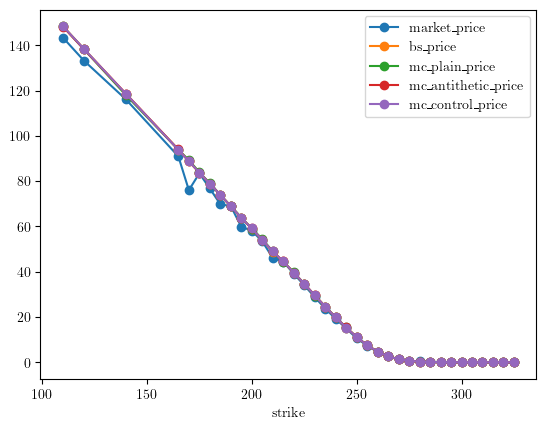

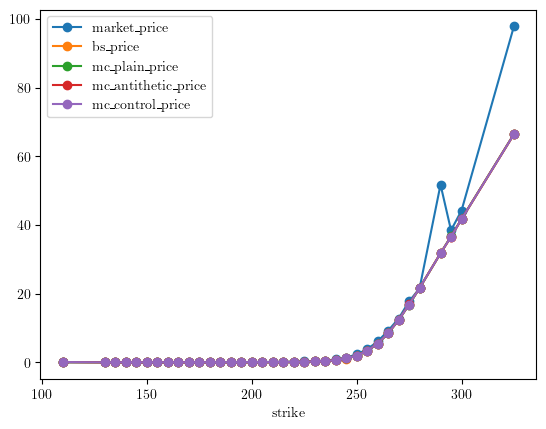

In [36]:
df_calls = calls_df.iloc[:, [0,1,4,5,7,9]].set_index('strike')
df_puts = puts_df.iloc[:, [0,1,4,5,7,9]].set_index('strike')

df_calls.plot(marker = 'o')
df_puts.plot(marker = 'o')

# Options Greeks (Binomial & Trinomial Models)

In discrete-time lattice models (Binomial/Trinomial), option Greeks are computed **numerically** by perturbing input parameters and observing changes in option prices along the tree.

---

### 1. Delta
Measures sensitivity of option price to changes in the underlying price.
- **Call / Put** (finite difference along the tree):  
$$
\Delta \approx \frac{V_{up} - V_{down}}{S_{up} - S_{down}}
$$
where \(V_{up}\) and \(V_{down}\) are option values at the next time step for upward and downward moves, and \(S_{up}\), \(S_{down}\) are corresponding asset prices.

---

### 2. Gamma
Measures the rate of change of Delta with respect to the underlying price.
$$
\Gamma \approx \frac{\Delta_{up} - \Delta_{down}}{0.5 \cdot (S_{up} - S_{down})}
$$
using the Deltas calculated at the first time step of the tree.

---

### 3. Vega
Measures sensitivity of option price to changes in volatility.
$$
\text{Vega} \approx \frac{V_{\sigma+\Delta\sigma} - V_{\sigma-\Delta\sigma}}{2 \Delta \sigma}
$$
where \(V_{\sigma+\Delta\sigma}\) and \(V_{\sigma-\Delta\sigma}\) are option prices computed with slightly higher/lower volatilities in the tree.

---

### 4. Theta
Measures sensitivity of option price to the passage of time.
$$
\Theta \approx \frac{V_{t} - V_{t+\Delta t}}{\Delta t}
$$
where \(V_{t+\Delta t}\) is the option value one time step forward in the lattice.

---

### 5. Rho
Measures sensitivity of option price to changes in interest rate.
$$
\rho \approx \frac{V_{r+\Delta r} - V_{r-\Delta r}}{2 \Delta r}
$$
where the lattice is recalculated for slightly higher and lower interest rates.

---

### 6. Vanna
Measures sensitivity of Delta to changes in volatility.
$$
\text{Vanna} \approx \frac{\Delta_{\sigma+\Delta\sigma} - \Delta_{\sigma-\Delta\sigma}}{2 \Delta \sigma}
$$

---

### 7. Volga (Vomma)
Measures sensitivity of Vega to changes in volatility.
$$
\text{Volga} \approx \frac{\text{Vega}_{\sigma+\Delta\sigma} - \text{Vega}_{\sigma-\Delta\sigma}}{2 \Delta \sigma}
$$

---

### 8. Charm
Measures sensitivity of Delta to the passage of time.
$$
\text{Charm} \approx \frac{\Delta_{t+\Delta t} - \Delta_{t}}{\Delta t}
$$

---

**Note:** In practice, these Greeks are computed by walking through the **binomial or trinomial tree** and using finite differences between neighboring nodes, rather than analytical formulas. This approach works for **both European and American options**, including early exercise features.


# **Application: BS Model and Greeks**

In [ ]:
!pip install yfinance numpy scipy matplotlib scienceplots --quiet
!apt-get update -qq
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

## Functions

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

class Black_Scholes:
    def __init__(self, S0, K, r, sigma, T, type):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.type = type

    def BS_Model(self):
        d1 = (np.log(self.S0/self.K) + ((self.r + 0.5 * self.sigma ** 2) * self.T))/(self.sigma * np.sqrt(self.T))
        d2 = d1 - (self.sigma * np.sqrt(self.T))

        if self.type == 'C':
            return self.S0 * norm.cdf(d1) - self.K * np.exp(- self.r * self.T) * norm.cdf(d2)

        else:
            return self.K * np.exp(- self.r * self.T) * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)


    def option_greeks(self):
        d1 = (np.log(self.S0/self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T)/(self.sigma * np.sqrt(self.T))
        d2 = d1 - (self.sigma * np.sqrt(self.T))

        if self.type =='C':
            delta = norm.cdf(d1)
            gamma = norm.pdf(d1)/(self.S0 * self.sigma * np.sqrt(self.T))
            vega = self.S0 * norm.pdf(d1) * np.sqrt(self.T)
            theta = - (self.S0 * self.sigma * norm.pdf(d1))/(2 * np.sqrt(self.T)) \
                    - (self.r * self.K * np.exp(- self.r * self.T) * norm.cdf(d2))
            rho = self.K * self.T * np.exp( - self.r * self.T) * norm.cdf(d2)
            vanna = - (norm.pdf(d1) * d2) / self.sigma
            volga = (vega * d1 * d2 )/ self.sigma
            charm = - norm.pdf(d1) * (((2 * self.r * self.T) - (d2 * self.sigma * np.sqrt(self.T)))/ \
                    (2 * self.T * self.sigma * np.sqrt(self.T)))

        else:
            delta = norm.cdf(d1) - 1
            gamma = norm.pdf(d1)/(self.S0 * self.sigma * np.sqrt(self.T))
            vega = self.S0 * np.sqrt(self.T) * norm.pdf(d1)
            theta = - (self.S0 * norm.pdf(d1) * self.sigma)/(2 * np.sqrt(self.T)) \
                    + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)
            rho = - self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-d2)
            vanna = - (norm.pdf(d1) * d2)/self.sigma
            volga = (vega * d1 * d2) / self.sigma
            charm = - norm.pdf(d1) * ((2 * self.r * self.T + d2 * self.sigma * np.sqrt(self.T))/\
                                     2 * self.T * self.sigma * np.sqrt(self.T))

        return {
            'Delta': round(delta, 4),
            'Gamma': round(gamma, 4),
            'Vega': round(vega, 4),
            'Theta': round(theta, 4),
            'Rho': round(rho, 4),
            'Vanna': round(vanna, 4),
            'Volga': round(volga, 4),
            'Charm': round(charm, 4)
        }

## Real-Option Data

In [ ]:
from datetime import datetime

def time_to_expiry(expiry):
    expiry_date = datetime.strptime(expiry, "%Y-%m-%d")
    today = datetime.today()
    T = (expiry_date - today).days / 365   # in years
    return max(T, 0)


In [ ]:
import yfinance as yf
from datetime import datetime

def get_option_chain(ticker):
    """Fetch current option chain for a ticker"""
    stock = yf.Ticker(ticker)

    # Get current price
    S = stock.history(period="1d")['Close'].iloc[-1]
    print(f"Current {ticker} price: ${S:.2f}")

    # Get nearest expiration (option expires in next 6 months)
    expirations = stock.options
    nearest_expiry = expirations[11]
    print(f"Nearest expiration: {nearest_expiry}")

    # Get option chain
    chain = stock.option_chain(nearest_expiry)
    calls = chain.calls
    puts = chain.puts

    return calls, puts, S, nearest_expiry


# tickers chosen for the options data
ticker = "AAPL"
calls, puts, S, expiry = get_option_chain(ticker)

# Show some calls
calls[['strike', 'lastPrice', 'impliedVolatility']].tail()

In [ ]:
# Calculating the Prices and sensitivites

r = 0.0437
T = time_to_expiry(expiry)

results = []

for i, row in calls.iterrows():
    K = row['strike']
    sigma = row['impliedVolatility']
    market_price = row['lastPrice']

    # Initialize Black–Scholes
    bs = Black_Scholes(S0=S, K=K, r=r, sigma=sigma, T=T, type='C')

    # Calculate model price & greeks
    model_price = bs.BS_Model()
    greeks = bs.option_greeks()

    results.append({
        "Strike": K,
        "MarketPrice": market_price,
        "BS_Price": round(model_price, 2),
        "IV": round(sigma, 4),
        **greeks
    })

df_bs = pd.DataFrame(results)
df_bs.head()


In [ ]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8,6))
plt.plot(df_bs["Strike"], df_bs["MarketPrice"], 'o-', color = 'blue', label="Market Price", alpha=0.8)
plt.plot(df_bs["Strike"], df_bs["BS_Price"], 's--', color = 'red', label="BS Price", alpha=0.8)
plt.xlabel("$K$")
plt.ylabel("Option Prices ($\$$)")
plt.title(f"Market vs. Black–Scholes Price for {ticker} ({expiry})")
plt.legend(frameon = False)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Mapping of Greeks to LaTeX symbols
greek_labels = {
    "Delta": r"$\Delta$",
    "Gamma": r"$\Gamma$",
    "Vega": r"$\nu$",
    "Theta": r"$\Theta$",
    "Rho": r"$\rho$",
    "Vanna": r"$\text{Vanna}$",
    "Volga": r"$\text{Volga}$",
    "Charm": r"$\text{Charm}$"
}

# Plotting the Greeks
fig, axes = plt.subplots(4, 2, figsize=(12,10))
greeks = ["Delta","Gamma","Vega","Theta","Rho", "Vanna", "Volga", "Charm"]

for i, greek in enumerate(greeks):
    ax = axes[i//2, i%2]
    ax.plot(df_bs["Strike"], df_bs[greek], 'o-', color = 'blue', label=greek_labels[greek])

    # Only show xlabel for the last row
    if i // 2 == 3:   # last row (row index 3)
        ax.set_xlabel("$K$")  # Strike
    ax.set_ylabel(greek_labels[greek])
    ax.grid(False)
    ax.legend(frameon=False)

fig.suptitle(f"Option Greeks for {ticker} ({expiry})", fontsize=16)
plt.tight_layout()
plt.show()


# **Binomial Model**

## Theoretical Example

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

class BinomialTreeOptionStable:
    def __init__(self, S0, K, T, r, sigma, N=200, option_type='C', exercise='E', q=0.0):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.N = max(N, int(T*500))  # ensure enough steps
        self.option_type = option_type
        self.exercise = exercise
        self.q = q

    def price_br(self):
        dt = self.T / self.N
        u = np.exp(self.sigma * np.sqrt(dt))
        d = 1 / u
        disc = np.exp(-self.r * dt)
        p = (np.exp((self.r - self.q) * dt) - d) / (u - d)
        p = np.clip(p, 0, 1)

        # log-space to avoid overflow
        logS = np.log(self.S0) + np.arange(self.N, -1, -1) * np.log(d) + np.arange(0, self.N + 1) * np.log(u)
        ST = np.exp(logS)

        if self.option_type == 'C':
            V = np.maximum(ST - self.K, 0)
        else:
            V = np.maximum(self.K - ST, 0)

        for i in range(self.N-1, -1, -1):
            V = disc * (p * V[1:i+2] + (1-p) * V[0:i+1])
            if self.exercise == 'A':
                logS_i = np.log(self.S0) + np.arange(i, -1, -1) * np.log(d) + np.arange(0, i+1) * np.log(u)
                ST_i = np.exp(logS_i)
                if self.option_type == 'C':
                    V = np.maximum(V, ST_i - self.K)
                else:
                    V = np.maximum(V, self.K - ST_i)
        return float(V[0])

    # Calcuating Greeks using Finite Differences methods
    def price_with(self, S0=None, sigma=None, r=None, T=None):
        old_S, old_sigma, old_r, old_T = self.S0, self.sigma, self.r, self.T
        if S0 is not None: self.S0 = S0
        if sigma is not None: self.sigma = sigma
        if r is not None: self.r = r
        if T is not None: self.T = T
        value = self.price_br()
        # restore
        self.S0, self.sigma, self.r, self.T = old_S, old_sigma, old_r, old_T
        return value

    def binomial_greeks(self, eps = 1e-4):
        V0 = self.price_br()

        # Delta
        V_plus = self.price_with(S0=self.S0 + eps)
        V_minus = self.price_with(S0=self.S0 - eps)
        delta = (V_plus - V_minus) / (2 * eps)

        # Gamma
        gamma = (V_plus - 2*V0 + V_minus) / (eps**2)

        # Vega
        V_plus = self.price_with(sigma=self.sigma + eps)
        V_minus = self.price_with(sigma=self.sigma - eps)
        vega = (V_plus - V_minus) / (2 * eps)

        # Theta
        V_minus = self.price_with(T=self.T - eps)
        theta = (V0 - V_minus) / eps

        # Rho
        V_plus = self.price_with(r=self.r + eps)
        V_minus = self.price_with(r=self.r - eps)
        rho = (V_plus - V_minus) / (2 * eps)

        # Vanna
        V_pp = self.price_with(S0=self.S0+eps, sigma=self.sigma+eps)
        V_pm = self.price_with(S0=self.S0+eps, sigma=self.sigma-eps)
        V_mp = self.price_with(S0=self.S0-eps, sigma=self.sigma+eps)
        V_mm = self.price_with(S0=self.S0-eps, sigma=self.sigma-eps)
        vanna = (V_pp - V_pm - V_mp + V_mm) / (4*eps**2)

        # Volga
        V_plus = self.price_with(sigma=self.sigma + eps)
        V_minus = self.price_with(sigma=self.sigma - eps)
        volga = (V_plus - 2*V0 + V_minus) / (eps**2)

        # Charm
        delta_T_minus = (self.price_with(S0=self.S0+eps, T=self.T-eps) -
                         self.price_with(S0=self.S0-eps, T=self.T-eps)) / (2*eps)
        charm = (delta - delta_T_minus) / eps

        return {
            "Delta": delta,
            "Gamma": gamma,
            "Vega": vega,
            "Theta": theta,
            "Rho": rho,
            "Vanna": vanna,
            "Volga": volga,
            "Charm": charm
        }


# Changing the strikes
if __name__ == "__main__":
    option_results_bn = []
    for i in np.arange(50, 150, 5):
        params = dict(S0=100, K=i, r=0.05, sigma=0.20, T=1, N=100)
        american_call = BinomialTreeOptionStable(**params, exercise='A', option_type='C').price_br()
        american_put = BinomialTreeOptionStable(**params, exercise='A', option_type='P').price_br()
        european_call = BinomialTreeOptionStable(**params, exercise='E', option_type='C').price_br()
        european_put = BinomialTreeOptionStable(**params, exercise='E', option_type='P').price_br()
        greeks = BinomialTreeOptionStable(**params, exercise='E', option_type='C').binomial_greeks()
        option_results_bn.append((i, american_call, american_put, european_call, european_put, greeks['Delta'], greeks['Gamma']))

# Creating the dataframe of the results
df_results_bn = pd.DataFrame(option_results_bn, columns=['Strike','American Call','American Put','European Call','European Put', 'Delta', 'Gamma'])
df_results_bn.set_index('Strike', inplace=True)

# Plotting the results
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(12,8))
df_results_bn.iloc[:,:4].plot(marker='o')
plt.xlabel('K')
plt.ylabel('Option Price')
plt.title('Option Prices using Binomial Tree')
plt.legend(frameon=False)
plt.grid(False)
plt.tight_layout()
plt.show()

## Market Chains

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import scienceplots

# Helper function
def time_to_expiry(expiry):
    expiry_date = datetime.strptime(expiry, "%Y-%m-%d")
    today = datetime.today()
    T = (expiry_date - today).days / 365   # in years
    return max(T, 0)

# Extracting the data
def get_option_chain(ticker):
    """Fetch current option chain for a ticker"""
    stock = yf.Ticker(ticker)

    # Get current price
    S = stock.history(period="1d")['Close'].iloc[-1]
    print(f"Current {ticker} price: ${S:.2f}")

    # Get nearest expiration (option expires in next 6 months)
    expirations = stock.options
    nearest_expiry = expirations[11]
    print(f"Nearest expiration: {nearest_expiry}")

    # Get option chain
    chain = stock.option_chain(nearest_expiry)
    calls = chain.calls
    puts = chain.puts

    return calls, puts, S, nearest_expiry


# tickers chosen for the options data
ticker = "AAPL"
calls, puts, S, expiry = get_option_chain(ticker)

# Show some calls
calls[['strike', 'lastPrice', 'impliedVolatility']].tail()


# Risk-free rate
r = 0.0437
T = time_to_expiry(expiry)

# Calculate Binomial Prices and Greeks
option_results_bn = []

for i, row in calls.iterrows():
    K = row['strike']
    sigma = row['impliedVolatility']
    market_price = row['lastPrice']

    params = dict(S0=S, K=K, r=r, sigma=sigma, T=T, N=150)  # N=150 for smoother tree

    # European Call
    bn_model = BinomialTreeOptionStable(**params, exercise='E', option_type='C')
    model_price = bn_model.price_br()
    greeks = bn_model.binomial_greeks()

    option_results_bn.append({
        "Strike": K,
        "MarketPrice": market_price,
        "Binomial": round(model_price, 2),
        "IV": round(sigma, 4),
        "Delta": round(greeks['Delta'], 4),
        "Gamma": round(greeks['Gamma'], 4),
        "Vega": round(greeks['Vega'], 4),
        "Theta": round(greeks['Theta'], 4),
        "Rho": round(greeks['Rho'], 4),
        "Vanna": round(greeks['Vanna'], 4),
        "Volga": round(greeks['Volga'], 4),
        "Charm": round(greeks['Charm'], 4)
    })

df_bn = pd.DataFrame(option_results_bn)
df_bn.set_index('Strike', inplace=True)
df_bn.head()

# Plotting the results
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(12,8))
df_bn[['MarketPrice','Binomial']].plot(marker='o', color = ['red', 'blue'])
plt.xlabel('K')
plt.ylabel('Option Price ')
plt.title(f'{ticker} Option Prices using Binomial Tree')
plt.legend(frameon=False)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
df_bn.head()

# **Trinomial Model**

To make it simple, I implement a very stable choice -- Boyle’s (1986) formulation for the trinomial tree:

$$
dx = \sigma \sqrt{2 \, dt}, \quad u = e^{dx}, \quad d = \frac{1}{u}
$$

The risk-neutral probabilities are:

$$
p_u = \frac{1}{2} \left[ \frac{\sigma^2 dt + \left( (r-q-\frac{1}{2}\sigma^2) dt \right)^2}{dx^2} + \frac{(r-q-\frac{1}{2}\sigma^2) dt}{dx} \right]
$$

$$
p_m = 1 - \frac{\sigma^2 dt + \left( (r-q-\frac{1}{2}\sigma^2) dt \right)^2}{dx^2}
$$

$$
p_d = \frac{1}{2} \left[ \frac{\sigma^2 dt + \left( (r-q-\frac{1}{2}\sigma^2) dt \right)^2}{dx^2} - \frac{(r-q-\frac{1}{2}\sigma^2) dt}{dx} \right]
$$

Where:  

- \(dx\) is the size of the log-price movement.  
- \(u\) and \(d\) are the up and down factors.  
- \(p_u, p_m, p_d\) are the probabilities of moving up, staying the same, or moving down in the next step.  
- \(r\) is the risk-free rate, \(q\) is the dividend yield, and \(\sigma\) is the volatility.


## Theoretical Example

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

class TrinomialTreeOptionStable:
    def __init__(self, S0, K, T, r, sigma, N=200, option_type='C', exercise='E', q=0.0):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.N = max(N, int(T*500))  # ensure enough steps
        self.option_type = option_type
        self.exercise = exercise
        self.q = q

    def price_tr(self):
        dt = self.T / self.N
        disc = np.exp(-self.r * dt)

        dx = self.sigma * np.sqrt(2 * dt)
        nu = (self.r - self.q - 0.5 * self.sigma**2) * dt

        pu = 0.5 * ((self.sigma**2 * dt + nu**2) / dx**2 + nu/dx)
        pm = 1 - (self.sigma**2 * dt + nu**2) / dx**2
        pd = 0.5 * ((self.sigma**2 * dt + nu**2) / dx**2 - nu/dx)

        # normalize to ensure pu+pm+pd = 1
        pu, pm, pd = np.clip([pu, pm, pd], 0, 1)
        s = pu + pm + pd
        pu, pm, pd = pu/s, pm/s, pd/s

        # terminal stock prices
        idx = np.arange(-self.N, self.N+1)
        ST = self.S0 * np.exp(idx * dx)

        # terminal payoff
        if self.option_type == 'C':
            V = np.maximum(ST - self.K, 0)
        else:
            V = np.maximum(self.K - ST, 0)

        # backward induction
        for j in range(self.N, 0, -1):
            V_new = np.zeros(2*j - 1)
            for k in range(len(V_new)):
                V_new[k] = disc * (pu*V[k] + pm*V[k+1] + pd*V[k+2])
            V = V_new

            # American adjustment
            if self.exercise == 'A':
                idx_j = np.arange(-j+1, j)  # exactly 2j-1 nodes
                ST_j = self.S0 * np.exp(idx_j * dx)
                if self.option_type == 'C':
                    V = np.maximum(V, ST_j - self.K)
                else:
                    V = np.maximum(V, self.K - ST_j)

        return float(V[0])


    # helper for Greeks
    def price_with(self, **kwargs):
        old = (self.S0, self.K, self.T, self.r, self.sigma, self.q)
        if "S0" in kwargs: self.S0 = kwargs["S0"]
        if "K" in kwargs: self.K = kwargs["K"]
        if "T" in kwargs: self.T = kwargs["T"]
        if "r" in kwargs: self.r = kwargs["r"]
        if "sigma" in kwargs: self.sigma = kwargs["sigma"]
        if "q" in kwargs: self.q = kwargs["q"]

        value = self.price_tr()
        self.S0, self.K, self.T, self.r, self.sigma, self.q = old
        return value

    def trinomial_greeks(self):
        eps = min(1e-4, self.S0 * 1e-3, self.T / 100)
        V0 = self.price_tr()

        # Delta
        V_plus = self.price_with(S0=self.S0 + eps)
        V_minus = self.price_with(S0=self.S0 - eps)
        delta = (V_plus - V_minus) / (2 * eps)

        # Gamma
        gamma = (V_plus - 2 * V0 + V_minus) / (eps ** 2)

        # Vega
        V_plus = self.price_with(sigma=self.sigma + eps)
        V_minus = self.price_with(sigma=self.sigma - eps)
        vega = (V_plus - V_minus) / (2 * eps)

        # Theta
        V_minus = self.price_with(T=self.T - eps)
        theta = (V0 - V_minus) / eps

        # Rho
        V_plus = self.price_with(r=self.r + eps)
        V_minus = self.price_with(r=self.r - eps)
        rho = (V_plus - V_minus) / (2 * eps)


        # Vanna
        V_pp = self.price_with(S0=self.S0+eps, sigma=self.sigma+eps)
        V_pm = self.price_with(S0=self.S0+eps, sigma=self.sigma-eps)
        V_mp = self.price_with(S0=self.S0-eps, sigma=self.sigma+eps)
        V_mm = self.price_with(S0=self.S0-eps, sigma=self.sigma-eps)
        vanna = (V_pp - V_pm - V_mp + V_mm) / (4*eps**2)

        # Volga
        V_plus = self.price_with(sigma=self.sigma + eps)
        V_minus = self.price_with(sigma=self.sigma - eps)
        volga = (V_plus - 2*V0 + V_minus) / (eps**2)

        # Charm
        delta_T_minus = (self.price_with(S0=self.S0+eps, T=self.T-eps) -
                         self.price_with(S0=self.S0-eps, T=self.T-eps)) / (2*eps)
        charm = (delta - delta_T_minus) / eps

        return {
            "Delta": delta,
            "Gamma": gamma,
            "Vega": vega,
            "Theta": theta,
            "Rho": rho,
            "Vanna": vanna,
            "Volga": volga,
            "Charm": charm
        }

# Simulating the strikes and options exercise
if __name__ == "__main__":
    strikes = np.arange(50, 150, 5)
    option_results = []
    for K in strikes:
        params = dict(S0=100, K=K, r=0.05, T=0.5616, sigma=0.2, N=150, q=0.0)
        american_call = TrinomialTreeOptionStable(**params, option_type='C', exercise='A').price_tr()
        american_put = TrinomialTreeOptionStable(**params, option_type='P', exercise='A').price_tr()
        european_call = TrinomialTreeOptionStable(**params, option_type='C', exercise='E').price_tr()
        european_put = TrinomialTreeOptionStable(**params, option_type='P', exercise='E').price_tr()
        greeks = TrinomialTreeOptionStable(**params, option_type='C', exercise='E').trinomial_greeks()

        option_results.append((K, american_call, american_put, european_call, european_put,
                               greeks['Delta'], greeks['Gamma']))

    df_tr = pd.DataFrame(option_results,
                         columns=['K', 'A-Call', 'A-Put', 'E-Call', 'E-Put', 'Delta', 'Gamma']).set_index('K')

    # Plotting the sample results
    plt.style.use(['science', 'notebook', 'grid'])
    plt.rcParams['text.usetex'] = True
    plt.figure(figsize=(12, 8))
    df_tr.iloc[:, :4].plot(marker='o')
    plt.xlabel('K')
    plt.ylabel('Option Price')
    plt.title('Option Prices using Trinomial Tree')
    plt.legend(frameon=False)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
df_tr.head()

## Market Chains

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import scienceplots

# Helper function
def time_to_expiry(expiry):
    expiry_date = datetime.strptime(expiry, "%Y-%m-%d")
    today = datetime.today()
    T = (expiry_date - today).days / 365   # in years
    return max(T, 0)

# Collecting the data as before
def get_option_chain(ticker):
    """Fetch current option chain for a ticker"""
    stock = yf.Ticker(ticker)

    # Get current price
    S = stock.history(period="1d")['Close'].iloc[-1]
    print(f"Current {ticker} price: ${S:.2f}")

    # Get nearest expiration (option expires in next 6 months)
    expirations = stock.options
    nearest_expiry = expirations[11]
    print(f"Nearest expiration: {nearest_expiry}")

    # Get option chain
    chain = stock.option_chain(nearest_expiry)
    calls = chain.calls
    puts = chain.puts

    return calls, puts, S, nearest_expiry


# tickers chosen for the options data
ticker = "AAPL"
calls, puts, S, expiry = get_option_chain(ticker)

# Show some calls
calls[['strike', 'lastPrice', 'impliedVolatility']].tail()


# Risk-free rate
r = 0.0437
T = time_to_expiry(expiry)

# Calculate Trinomial Prices and Greeks
option_results_tr = []

for i, row in calls.iterrows():
    K = row['strike']
    sigma = row['impliedVolatility']  # Already in decimal
    market_price = row['lastPrice']

    params = dict(S0=S, K=K, r=r, sigma=sigma, T=T, N=150)  # N=150 for smoother tree

    # European Call
    tr_model = TrinomialTreeOptionStable(**params, exercise='E', option_type='C')
    model_price = tr_model.price_tr()
    greeks = tr_model.trinomial_greeks()

    option_results_tr.append({
        "Strike": K,
        "MarketPrice": market_price,
        "Trinomial": round(model_price, 2),
        "IV": round(sigma, 4),
        "Delta": round(greeks['Delta'], 4),
        "Gamma": round(greeks['Gamma'], 4),
        "Vega": round(greeks['Vega'], 4),
        "Theta": round(greeks['Theta'], 4),
        "Rho": round(greeks['Rho'], 4),
        "Vanna": round(greeks['Vanna'], 4),
        "Volga": round(greeks['Volga'], 4),
        "Charm": round(greeks['Charm'], 4)
    })

df_tr = pd.DataFrame(option_results_tr)
df_tr.set_index('Strike', inplace=True)
df_tr.head()

# Plotting the results
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(12,8))
df_tr[['MarketPrice','Trinomial']].plot(marker='o', color = ['red', 'blue'])
plt.xlabel('K')
plt.ylabel('Option Price ')
plt.title(f'{ticker} Option Prices using Trinomial Tree')
plt.legend(frameon=False)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
df_tr.head()

# **Comparing Results**

In [ ]:
print(df_bs.columns)
print(df_bn.columns)
print(df_tr.columns)

In [ ]:
# Plotting the Prices and strikes
import matplotlib.pyplot as plt
import scienceplots

# Merge the three dataframes on Strike
df_all = df_bs.merge(df_bn, on="Strike", suffixes=("_BS", "_BN"))
df_all = df_all.merge(df_tr, on="Strike")
df_all.rename(columns=lambda x: x.replace("_x","_TR").replace("_y",""), inplace=True)

# Model Prices vs Market Prices
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8,6))
plt.plot(df_all["Strike"], df_all["MarketPrice"], "o-", color = 'black', label="Market")
plt.plot(df_all["Strike"], df_all["BS_Price"], "o-", color = 'red', label="Black-Scholes")
plt.plot(df_all["Strike"], df_all["Binomial"], "o-", color = 'blue',  label="Binomial")
plt.plot(df_all["Strike"], df_all["Trinomial"], "o-", color = 'green' , label="Trinomial")
plt.xlabel("K")
plt.ylabel("Option Price ($\$$)")
plt.suptitle("Option Prices: Market vs Models", fontsize = 18)
plt.title(f"{ticker} {expiry}", fontsize = 12)
plt.legend(frameon = False, fontsize = 12)
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
# Plotting the Greeks
df_bn = df_bn.drop(columns=["level_0", "index"], errors="ignore")
df_tr = df_tr.drop(columns=["level_0", "index"], errors="ignore")

greeks = ["Delta", "Gamma", "Vega", "Theta", "Rho", "Vanna", "Volga", "Charm"]

df_bs_ren = df_bs.copy()
df_bs_ren.rename(columns={g: f"{g}_BS" for g in greeks}, inplace=True)

df_bn_ren = df_bn.copy()
df_bn_ren.rename(columns={g: f"{g}_BN" for g in greeks}, inplace=True)

df_tr_ren = df_tr.copy()
df_tr_ren.rename(columns={g: f"{g}_TR" for g in greeks}, inplace=True)

# Merge all
df_all = df_bs_ren.merge(df_bn_ren, on=["Strike", "MarketPrice", "IV"])
df_all = df_all.merge(df_tr_ren, on=["Strike", "MarketPrice", "IV"])

# Symbol map for titles
symbol_map = {
    "Delta": r"$\Delta$",
    "Gamma": r"$\Gamma$",
    "Vega": r"$\nu$",
    "Theta": r"$\Theta$",
    "Rho": r"$\rho$",
    "Vanna": "Vanna",
    "Volga": "Volga",
    "Charm": "Charm"
}

# Plot (4x2)
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
fig, axes = plt.subplots(4, 2, figsize=(12, 14), sharex=True)

for ax, greek in zip(axes.flat, greeks):
    ax.plot(df_all["Strike"], df_all[f"{greek}_BS"], "-o", color='black', lw=1.2, label="BS")
    ax.plot(df_all["Strike"], df_all[f"{greek}_BN"], "-o", color='blue', lw=1.2, label="Binomial")
    ax.plot(df_all["Strike"], df_all[f"{greek}_TR"], "-o", color='red', lw=1.2, label="Trinomial")
    ax.set_title(symbol_map[greek], fontsize=12)
    ax.grid(False)
    ax.legend(frameon=False, fontsize=10)

axes[-1,0].set_xlabel("K")
axes[-1,1].set_xlabel("K")

fig.suptitle("European Call Option Greeks: BS vs Binomial vs Trinomial", fontsize=14)
plt.tight_layout()
plt.show()

# **Reflections**

When comparing Greeks across **Black–Scholes (BS)**, **Binomial (BN)**, and **Trinomial (TR)** models, we observe noticeable differences.  
These differences arise from the theoretical assumptions and numerical approximations of each method.

---

### 1. Assumptions

- **Black–Scholes (BS)**
  - Continuous trading, frictionless markets (no transaction costs, taxes, or bid–ask spreads).
  - Constant volatility (`σ`) and risk-free interest rate (`r`).
  - Lognormal distribution of underlying asset prices.
  - European-style exercise (no early exercise).
  - No dividends (unless modified with continuous yield `q`).

- **Binomial and Trinomial Trees**
  - Discrete-time approximation to the continuous process.
  - Finite number of steps (`N`) to maturity.
  - Asset prices can only move to specific discrete states (up, down, or neutral in TR).
  - Risk-neutral valuation principle is applied at each node.
  - Can handle **American options** (early exercise possible).
  - Convergence to BS requires large `N`.

---

### 2. Limitations

- **Black–Scholes**
  - Unrealistic constant volatility and interest rate assumption.
  - Poor fit to market data with volatility smiles/skews.
  - Cannot value American options (except dividend-free calls).
  - Greeks may diverge from reality under stochastic volatility or jumps.

- **Binomial Tree**
  - Greeks are sensitive to the number of steps (`N`).
  - Approximation errors if `N` is too small.
  - Slower convergence compared to BS.
  - Computationally more expensive than closed-form BS.

- **Trinomial Tree**
  - More stable than Binomial but still dependent on `N`.
  - Implementation complexity increases with more steps.
  - Still assumes constant volatility and interest rates.
  - Larger memory requirement for storing nodes.

---

### 3. Reasons for Differences in Greeks

- **Discretization error**: Binomial/Trinomial trees approximate continuous dynamics; errors shrink as `N → ∞`.
- **Boundary conditions**: Early exercise features (American options) create deviations in Delta, Theta, and Charm.
- **Numerical stability**: Vega, Volga, and higher-order Greeks are particularly unstable in tree methods due to finite differences.
- **Market vs Model**: Market-implied Greeks incorporate volatility smiles/skews, while BS/trees assume flat volatility.

---

### 4. Ways to Improve

- **Increase steps (`N`)** in Binomial/Trinomial trees for better convergence to BS.
- **Use implied volatility surface** instead of constant `σ` for more realistic Greeks.
- **Calibrate models** (e.g., local volatility, stochastic volatility, SABR, Heston) to market data.
- **Variance reduction techniques** for numerical stability in Vega, Volga, and higher-order Greeks.
- **Hybrid approaches**: Use BS for speed, and trees or finite difference PDE solvers for early-exercise and exotic features.
- **Monte Carlo with Greeks via pathwise or likelihood ratio methods** for robustness under complex dynamics.

---

📌 **Takeaway:**  
- **BS Greeks** are fast and analytically neat but rely on restrictive assumptions.  
- **Binomial/Trinomial Greeks** provide flexibility (esp. for American options) but introduce discretization error.  
- For practical trading and risk management, **market-calibrated models with volatility surfaces** give the most reliable Greeks.


# **References**

- Black, F., & Scholes, M. (1973). The pricing of options and corporate liabilities. *Journal of Political Economy*, 81(3), 637–654.

- Merton, R. C. (1973). Theory of rational option pricing. *Bell Journal of Economics and Management Science*, 4(1), 141–183.

- Hull, J. C. (2017). *Options, futures, and other derivatives (11th ed.)*. Pearson.

- Wilmott, P. (2006). *Paul Wilmott introduces quantitative finance (2nd ed.)*. Wiley.

- Haug, E. G. (2007). *The complete guide to option pricing formulas (2nd ed.)*. McGraw-Hill.

- Shreve, S. E. (2004). *Stochastic calculus for finance II: Continuous-time models*. Springer.




<span style="font-family:'cursive'; font-size:10px;">
&nbsp;<strong>Disclaimer:</strong> <br>  
The content and code in this notebook are intended for educational and illustrative purposes only. Option pricing involves risk, and the models presented here rely on assumptions that may not fully reflect real market conditions. Users should exercise caution, perform their own research, and consult a qualified financial professional before making any investment or trading decisions.&nbsp;
</span>